In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=2947dffe4d487d1305404b34a83e9ad0b771375e85cd060d780d4809f7d83484
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
# import pyspark libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, date_trunc, desc, asc, to_date
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import Window

from pyspark.ml.feature import OneHotEncoder, IndexToString, StringIndexer, Normalizer, StandardScaler, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import python libraries
import datetime as dt
import numpy as np
import pandas as pd

In [ ]:
# Importing and configuration of Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Super Market Campaign analysis with PySpark").getOrCreate()

In [ ]:
# As we have already learnt about reading a Dataframe in our previous notebooks so we would directly read our notebook now
data=spark.read.csv('/content/drive/MyDrive/code_files/Sri/Pyspark/Supermarket Campaign analysis/marketing_data.csv',inferSchema=True,header=True)
# By default the show function will give us  20 rows but if need fewer rows then we can mention as a parameter inside the function.
data.show(5)

+-----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
|   ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|
+-----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+
| 1826|      1970|Graduation|      Divorced|84,835|      0|       0|    6/16/14|      0|     189|      104|            379|            111|             189|         2

In [ ]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- Complain: integer (nullable = true)



In [ ]:
print('Without any conversion: ',(data.count(), len(data.columns))) 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
pandasDF=data.toPandas()
print('By converting from spark to Pandas: ',pandasDF.shape)

Without any conversion:  (2240, 22)
By converting from spark to Pandas:  (2240, 22)


In [ ]:
data.columns

['ID',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Response',
 'Complain']

In [ ]:
for i in data.columns:
  print("missing in",i,data.filter(data[i].isNull()).count())

missing in ID 0
missing in Year_Birth 0
missing in Education 0
missing in Marital_Status 0
missing in Income 24
missing in Kidhome 0
missing in Teenhome 0
missing in Dt_Customer 0
missing in Recency 0
missing in MntWines 0
missing in MntFruits 0
missing in MntMeatProducts 0
missing in MntFishProducts 0
missing in MntSweetProducts 0
missing in MntGoldProds 0
missing in NumDealsPurchases 0
missing in NumWebPurchases 0
missing in NumCatalogPurchases 0
missing in NumStorePurchases 0
missing in NumWebVisitsMonth 0
missing in Response 0
missing in Complain 0


In [ ]:
data.describe().show()

+-------+------------------+---------+--------------+------+-------------------+------------------+-----------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+
|summary|        Year_Birth|Education|Marital_Status|Income|            Kidhome|          Teenhome|Dt_Customer|           Recency|         MntWines|         MntFruits|   MntMeatProducts|  MntFishProducts| MntSweetProducts|      MntGoldProds| NumDealsPurchases|   NumWebPurchases|NumCatalogPurchases| NumStorePurchases| NumWebVisitsMonth|           Response|           Complain|               Age|
+-------+------------------+---------+--------------+------+-------------------+------------------+-----------+------------------+-----------------+------------------+------------------+-----------------+--

In [ ]:
data.toPandas().describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Year_Birth,2240.0,NaN,NaN,NaN,1968.805804,11.984069,1893.0,1959.0,1970.0,1977.0,1996.0
Education,2240,5,Graduation,1127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,2240,8,Married,864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,2216,1974,"7,500",12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kidhome,2240.0,NaN,NaN,NaN,0.444196,0.538398,0.0,0.0,0.0,1.0,2.0
Teenhome,2240.0,NaN,NaN,NaN,0.50625,0.544538,0.0,0.0,0.0,1.0,2.0
Dt_Customer,2240,663,8/31/12,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recency,2240.0,NaN,NaN,NaN,49.109375,28.962453,0.0,24.0,49.0,74.0,99.0
MntWines,2240.0,NaN,NaN,NaN,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,NaN,NaN,NaN,26.302232,39.773434,0.0,1.0,8.0,33.0,199.0


In [ ]:
# let's check for duplicate values in the data
data.toPandas().duplicated().sum()

0

In [ ]:
data.dtypes

[('Year_Birth', 'int'),
 ('Education', 'string'),
 ('Marital_Status', 'string'),
 ('Income', 'string'),
 ('Kidhome', 'int'),
 ('Teenhome', 'int'),
 ('Dt_Customer', 'string'),
 ('Recency', 'int'),
 ('MntWines', 'int'),
 ('MntFruits', 'int'),
 ('MntMeatProducts', 'int'),
 ('MntFishProducts', 'int'),
 ('MntSweetProducts', 'int'),
 ('MntGoldProds', 'int'),
 ('NumDealsPurchases', 'int'),
 ('NumWebPurchases', 'int'),
 ('NumCatalogPurchases', 'int'),
 ('NumStorePurchases', 'int'),
 ('NumWebVisitsMonth', 'int'),
 ('Response', 'int'),
 ('Complain', 'int'),
 ('Age', 'int')]

In [ ]:
data = data.drop("ID")

In [ ]:
# To calculate age we'll subtract the year 2016 because variables account for the last 2 years
# and we have customers registered till 2014 only
# We need to convert strings values to dates first to use subtraction

from pyspark.sql.functions import year, expr
data = data.withColumn("Age", expr("2016 - year(to_date(CAST(Year_Birth AS STRING), 'yyyy'))"))
data.sort("Age").select("Age")


DataFrame[Age: int]

In [ ]:
data.toPandas()[data.toPandas()["Age"] > 100]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age
513,1893,2n Cycle,Single,"60,182",0,1,5/17/14,23,8,0,...,0,2,1,1,0,2,4,0,0,123
827,1899,PhD,Together,"83,532",0,0,9/26/13,36,755,144,...,64,224,1,4,6,4,1,0,0,117
2233,1900,2n Cycle,Divorced,"36,640",1,0,9/26/13,99,15,6,...,4,25,1,2,1,2,5,0,1,116


- The Year_Birth for some 3 observations seems to be incorrect as the age seems to be extremely  high
- Replacing them with some other values might not be the best thing to do
We will drop these 3 observations

In [ ]:
# Dropping the 3 observations with age > 100
data = data.filter(col("Age") <= 100)

In [ ]:
data = data.drop("Dt_Customer")

In [ ]:

# Making a list of all categorical variables
cat_col = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "Complain",
    "Response",

]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data.toPandas()[column].value_counts())
    print("-" * 40)

Graduation    1127
PhD            485
Master         370
2n Cycle       201
Basic           54
Name: Education, dtype: int64
----------------------------------------
Married     864
Together    579
Single      479
Divorced    231
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64
----------------------------------------
0    1291
1     898
2      48
Name: Kidhome, dtype: int64
----------------------------------------
0    1156
1    1029
2      52
Name: Teenhome, dtype: int64
----------------------------------------
0    2217
1      20
Name: Complain, dtype: int64
----------------------------------------
0    1903
1     334
Name: Response, dtype: int64
----------------------------------------


- In education, 2n cycle and Master means the same thing. We can combine these two categories.
- There are many categories in marital status. We can combine the categories 'Alone', 'Absurd' and 'YOLO' with 'Single' and 'Together' categories with 'Married'.
- There are only 21 customers who complained in the last two years.
- We have 1906 observations for the 0 class but only 334 observations for class 1.
- There are only three years in the customer registration data.

In [ ]:
from pyspark.sql.functions import when

# Replacing 2n Cycle with Master
data = data.withColumn("Education", when(data["Education"] == "2n Cycle", "Master").otherwise(data["Education"]))

# Replacing YOLO, Alone, Absurd with single and Together with Married
data = data.withColumn("Marital_Status", when(data["Marital_Status"].isin("YOLO", "Alone", "Absurd"), "Single").otherwise(data["Marital_Status"]))
data = data.withColumn("Marital_Status", when(data["Marital_Status"] == "Together", "Married").otherwise(data["Marital_Status"]))


**We can add a column - total amount spent by each customer in the last 2 years**

In [ ]:
data = data.selectExpr("*", "MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds as Total_Amount_Spent")


## EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# It would be easy to do visualization on pandas dataframe so we would convert the pyspark dataframe to pandas dataframe
df = data.toPandas()

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
df['Income'] = df['Income'].str.replace(',', '').astype(float)


In [ ]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Total_Amount_Spent
0,1970,Graduation,Divorced,84835.0,0,0,0,189,104,379,...,4,6,1,1,0,46,NaN,NaN,NaN,1190
1,1961,Graduation,Single,57091.0,0,0,0,464,5,64,...,3,7,5,1,0,55,NaN,NaN,NaN,577
2,1958,Graduation,Married,67267.0,0,1,0,134,11,59,...,2,5,2,0,0,58,NaN,NaN,NaN,251
3,1967,Graduation,Married,32474.0,1,1,0,10,0,1,...,0,2,7,0,0,49,NaN,NaN,NaN,11
4,1989,Graduation,Single,21474.0,1,0,0,6,16,24,...,1,2,7,1,0,27,NaN,NaN,NaN,91


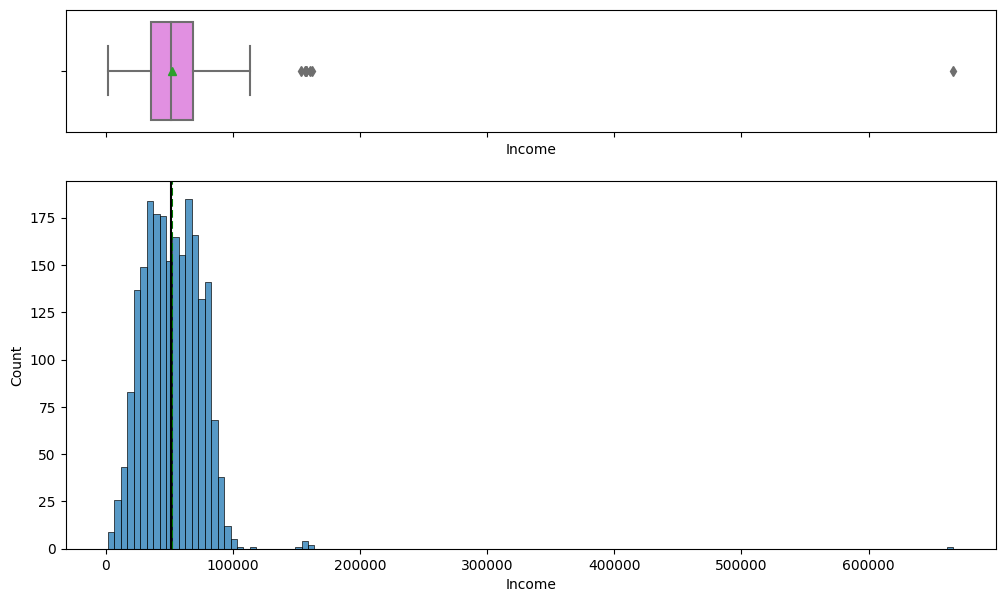

In [ ]:
# observations on Income
histogram_boxplot(df, "Income")

- We can see there are some outliers in the income variable.
- Some variation is always expected in real-world scenarios for the income variable but we can remove the data point on the extreme right end of the boxplot as it can be a data entry error.

In [ ]:
df[df["Income"] > 200000]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Total_Amount_Spent
526,1977,Graduation,Married,666666.0,1,0,23,9,14,18,...,1,3,6,0,0,39,NaN,NaN,NaN,62


In [ ]:
# Dropping observaion with income greater than 20000. Since there is just 1 such observation
df.drop(index=df[df.Income > 200000].index, inplace=True)

`MntMeatProducts`

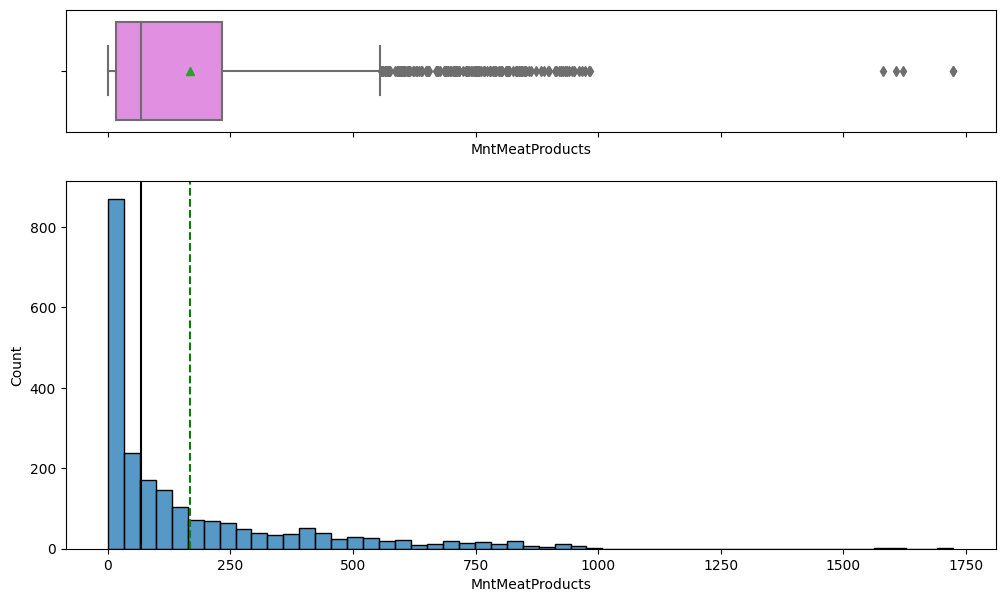

In [ ]:
# observations on MntMeatProducts
histogram_boxplot(df, "MntMeatProducts")

- The distribution for the amount spent on meat products is highly skewed to the right.
- We can see that there are some extreme observations in the variable that can be considered as outliers as they very far from the rest of the values. 
- We can cap the value of the variable to the next highest value.

In [ ]:
# Checking 10 largest values of amount spend on meat products
df.MntMeatProducts.nlargest(10)

325     1725
959     1725
497     1622
1211    1607
2202    1582
1919     984
53       981
992      974
2019     968
1336     961
Name: MntMeatProducts, dtype: int32

In [ ]:
df[df["MntMeatProducts"] > 1580]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Total_Amount_Spent
325,1977,Graduation,Married,157146.0,0,0,13,1,0,1725,...,28,0,1,0,0,39,NaN,NaN,NaN,1730
497,1982,PhD,Married,160803.0,0,0,21,55,16,1622,...,28,1,0,0,0,34,NaN,NaN,NaN,1717
959,1979,Graduation,Married,2447.0,1,0,42,1,1,1725,...,28,0,1,0,0,37,NaN,NaN,NaN,1730
1211,1978,Master,Married,NaN,0,0,53,32,2,1607,...,0,1,0,0,0,38,NaN,NaN,NaN,1679
2202,1973,PhD,Married,157243.0,0,1,98,20,2,1582,...,22,0,0,0,0,43,NaN,NaN,NaN,1608


- The values for MntMeatProducts for these 5 observations need not be incorrect
- So, dropping them will lead us to loss of information
- Let's cap them with next highest value

In [ ]:
# Capping values for amount spent on meat products at next highest value i.e. 984
df["MntMeatProducts"].clip(upper=984, inplace=True)

`MntSweetProducts`

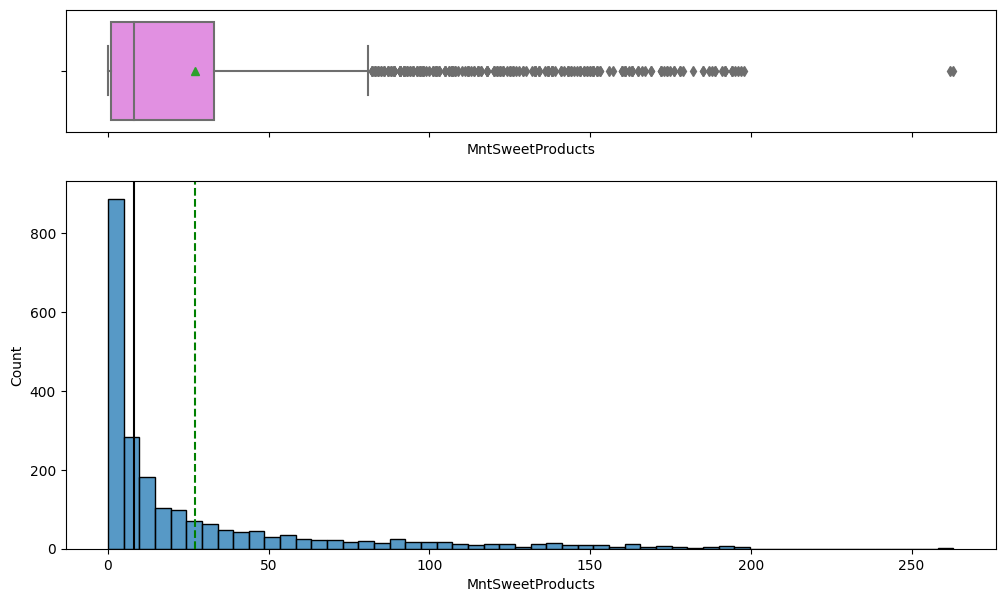

In [ ]:
# observations on MntSweetProducts
histogram_boxplot(df, "MntSweetProducts")

- The distribution for the amount spent on sweet products is right-skewed 
- There is one observation to the right extreme which can be considered as an outlier. 
- We will not remove all such data points as they represent real market trends but we can cap some of the extreme values.

In [ ]:
df[df["MntSweetProducts"] > 200]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Total_Amount_Spent
210,1945,PhD,Single,113734.0,0,0,9,6,2,3,...,0,0,1,0,0,71,NaN,NaN,NaN,277
449,1986,Graduation,Single,NaN,1,0,19,5,1,3,...,0,0,1,0,0,30,NaN,NaN,NaN,637


- The values for MntSweetProducts for these 2 observations need not be incorrect
- So, dropping them will lead us to loss of information
- Let's cap them with next highest value

In [ ]:
# Capping values for amount spent on sweet products at 198
df["MntSweetProducts"].clip(upper=198, inplace=True)

`MntGoldProds`

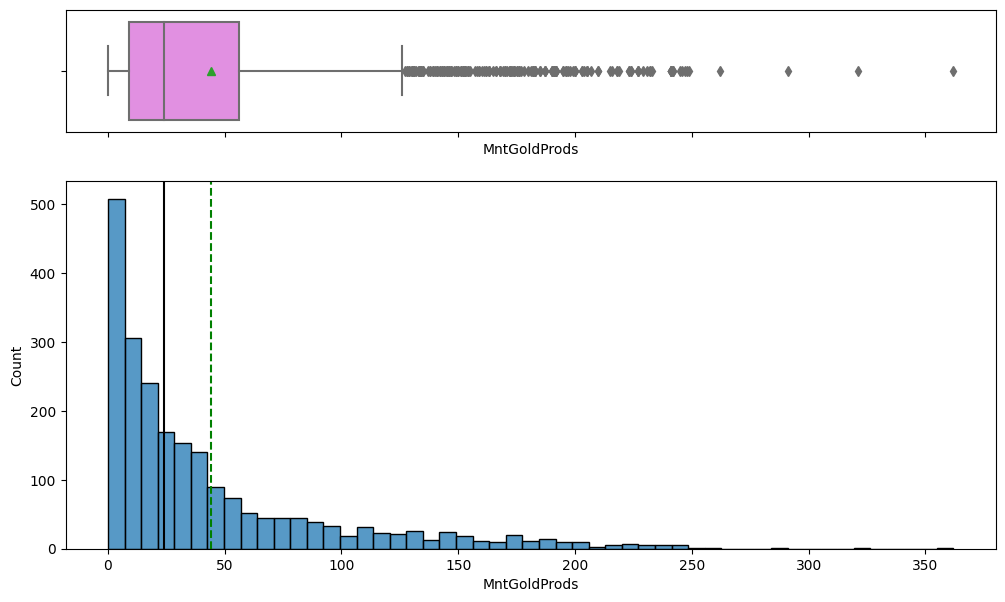

In [ ]:
# observations on MntGoldProds
histogram_boxplot(df, "MntGoldProds")

- The distribution for the amount spent on gold products is right-skewed 
- There are some outliers in the amount spent on gold products. We will not remove all such data points as they represent real market trends but we can cap some of the extreme values.

In [ ]:
df[df["MntGoldProds"] > 250]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Total_Amount_Spent
14,1969,Graduation,Married,4428.0,0,1,0,16,4,12,...,0,0,1,0,0,47,NaN,NaN,NaN,359
60,1982,Master,Single,6560.0,0,0,2,67,11,26,...,0,1,17,0,0,34,NaN,NaN,NaN,373
449,1986,Graduation,Single,NaN,1,0,19,5,1,3,...,0,0,1,0,0,30,NaN,NaN,NaN,637
2061,1966,PhD,Single,7144.0,0,2,92,81,4,33,...,1,1,0,0,0,50,NaN,NaN,NaN,416


- The values for MntGoldProds for these 4 observations need not be incorrect
- So, dropping them will lead us to loss of information
- Let's cap them with next highest value

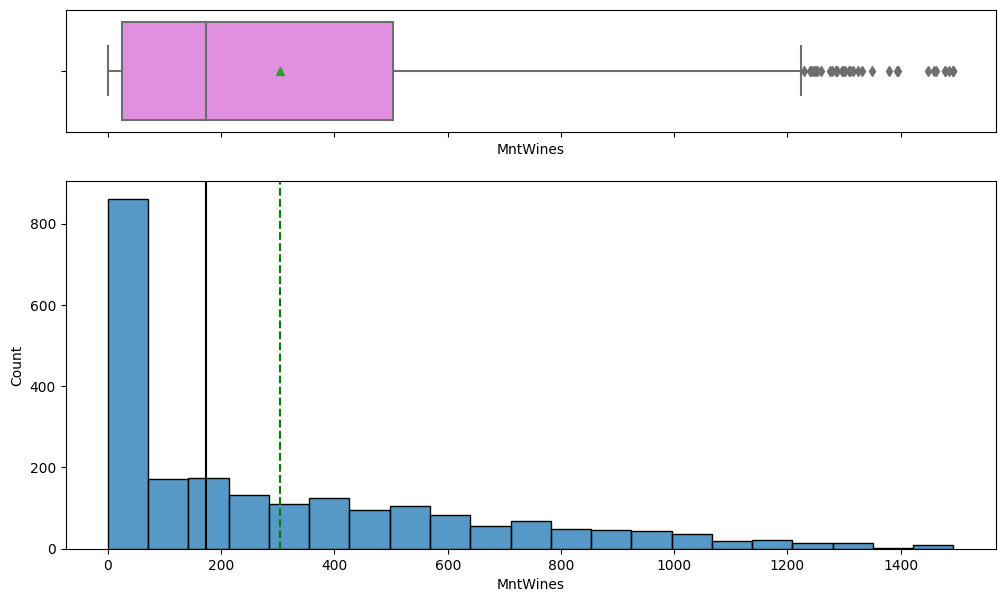

In [ ]:
# observations on MntWines
histogram_boxplot(df, "MntWines")

- The distribution for the amount spent on wines is highly skewed to the right
- As the median of the distribution is less than 200, more than 50% of customers have spent less than 200 on wines.
- There are some outliers on the right end of the boxplot but we will not treat them as some variation is always expected in real-world scenarios for variables like amount spent.

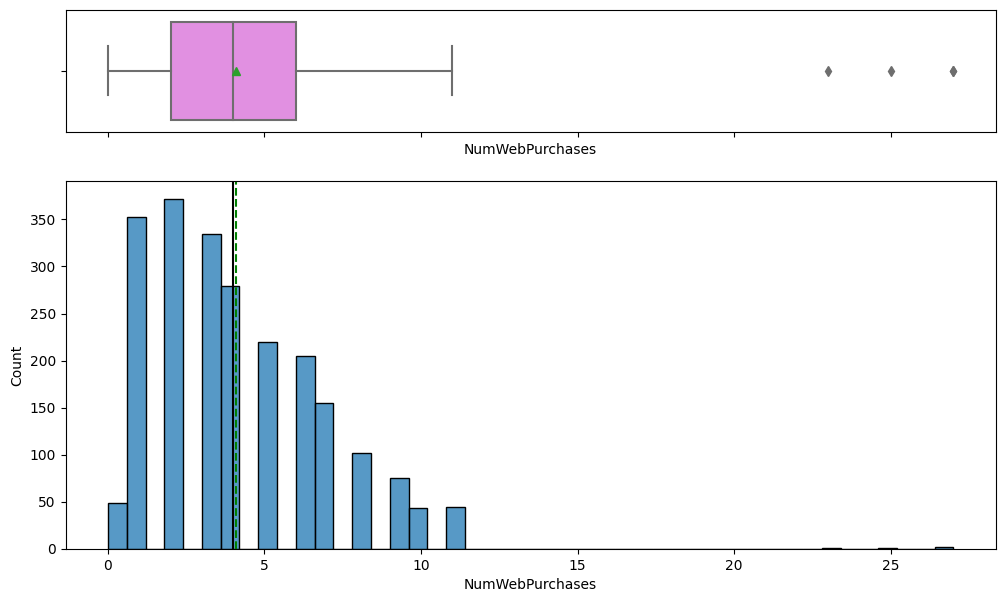

In [ ]:
# observations on NumWebPurchases
histogram_boxplot(df, "NumWebPurchases")

- The median of the distribution is 4 i.e. 50% of customers have 4 or less than 4 web purchases. 
- We can see that there are some extreme observations in the variable. We can cap these values to the next highest number of purchases.

In [ ]:
df[df["NumWebPurchases"] > 15]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Total_Amount_Spent
14,1969,Graduation,Married,4428.0,0,1,0,16,4,12,...,0,0,1,0,0,47,NaN,NaN,NaN,359
210,1945,PhD,Single,113734.0,0,0,9,6,2,3,...,0,0,1,0,0,71,NaN,NaN,NaN,277
449,1986,Graduation,Single,NaN,1,0,19,5,1,3,...,0,0,1,0,0,30,NaN,NaN,NaN,637
2061,1966,PhD,Single,7144.0,0,2,92,81,4,33,...,1,1,0,0,0,50,NaN,NaN,NaN,416


- The values for NumWebPurchases for these 4 observations need not be incorrect
- So, dropping them will lead us to loss of information
- Let's cap them with next highest value

In [ ]:
# Capping values for number of web purchases at 11
df["NumWebPurchases"].clip(upper=11, inplace=True)

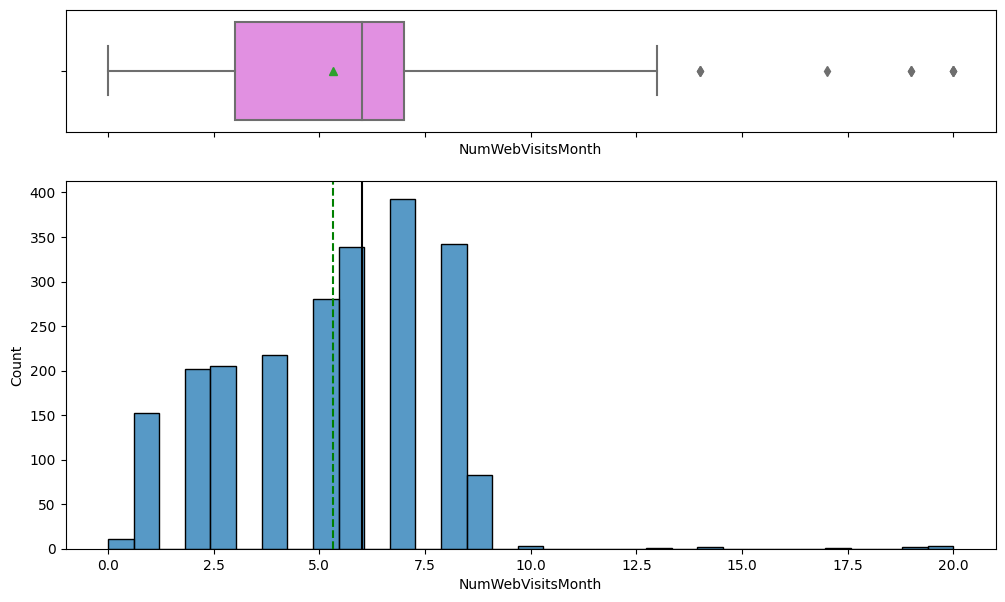

In [ ]:
# observations on NumWebVisitsMonth
histogram_boxplot(df, "NumWebVisitsMonth")

- The distribution for the number of visits in a month is skewed and has some outliers at the right end.
- We will not treat this as this represents a general market trend

`NumCatalogPurchases`

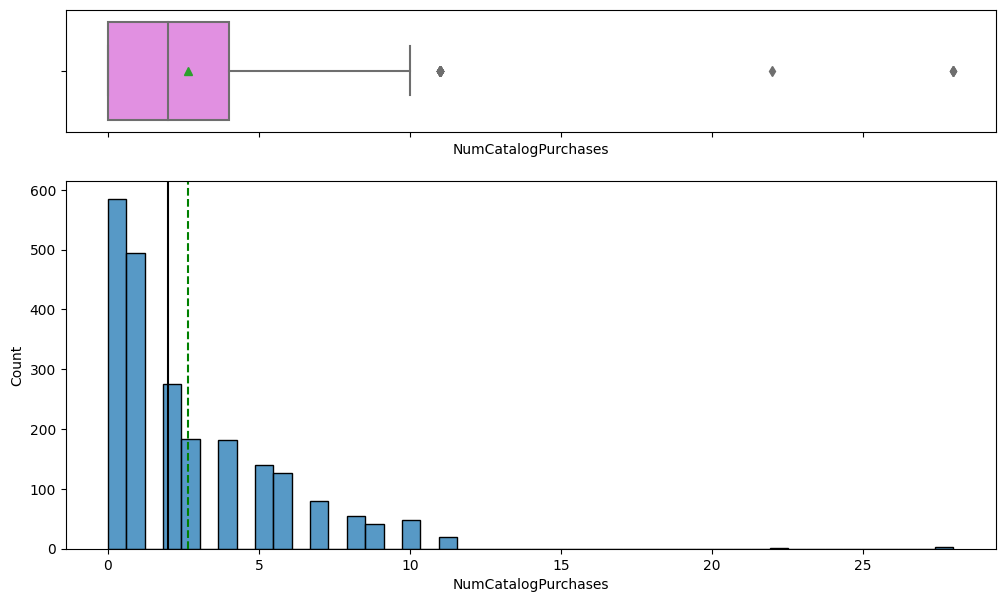

In [ ]:
# observations on NumCatalogPurchases
histogram_boxplot(df, "NumCatalogPurchases")

- The most number of observations are for 0 catalog purchases.
- The median of the distribution is 2 i.e. 50% of customers have 2 or less than 2 catalog purchases. 
- We can see that there is two extreme observation in the variable. We can cap these values to the next highest number of purchases.

In [ ]:
df[df["NumCatalogPurchases"] > 15]

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Total_Amount_Spent
325,1977,Graduation,Married,157146.0,0,0,13,1,0,984,...,28,0,1,0,0,39,NaN,NaN,NaN,1730
497,1982,PhD,Married,160803.0,0,0,21,55,16,984,...,28,1,0,0,0,34,NaN,NaN,NaN,1717
959,1979,Graduation,Married,2447.0,1,0,42,1,1,984,...,28,0,1,0,0,37,NaN,NaN,NaN,1730
2202,1973,PhD,Married,157243.0,0,1,98,20,2,984,...,22,0,0,0,0,43,NaN,NaN,NaN,1608


In [ ]:
# Capping values for number of catalog purchases at 11
df["NumCatalogPurchases"].clip(upper=11, inplace=True)

`Complain`

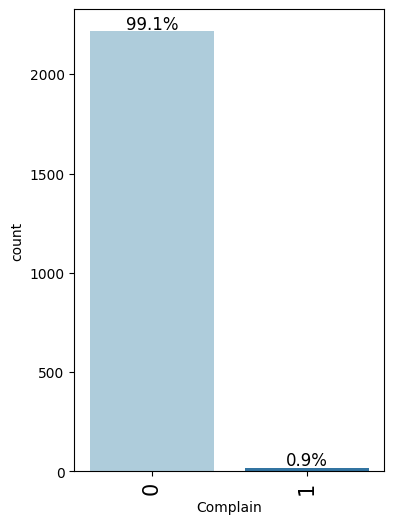

In [ ]:
# observations on Complain
labeled_barplot(df, "Complain", perc=True)

- Approx 99% of customers had no complaint in the last 2 years. This might be because the company provides good services or might be due to the lack of feedback options for customers.

`Teenhome`

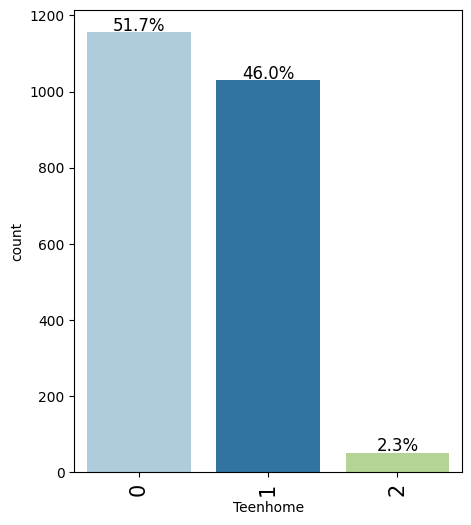

In [ ]:
# observations on Teenhome
labeled_barplot(df, "Teenhome", perc=True)

- Majority of the customers i.e. ~52% customers have no teen at home
- There are very few customers, only ~2%, with a number of teens greater than 1 

`Response`

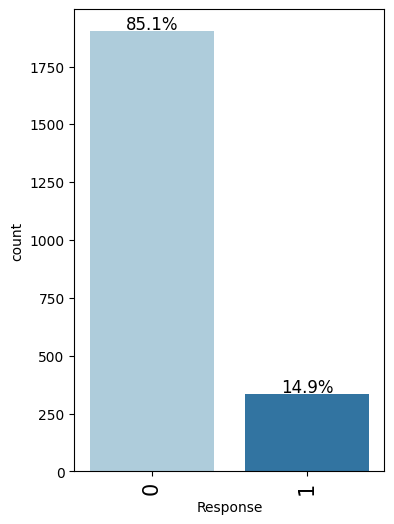

In [ ]:
# observations on Response
labeled_barplot(df, "Response", perc=True)

- Approx 85% customer's response was NO in the last campaign.
- This shows that the distribution of classes in the target variable is imbalanced. We have only ~15% observations where response is YES.

### Bivarriate analyis

`MntWines,MntGoldProds,MntMeatProducts,MntFruits,MntFishProducts,MntSweetProducts`

In [ ]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Reg_year,Reg_quarter,Reg_month,Total_Amount_Spent
0,1970,Graduation,Divorced,84835.0,0,0,0,189,104,379,...,4,6,1,1,0,46,NaN,NaN,NaN,1190
1,1961,Graduation,Single,57091.0,0,0,0,464,5,64,...,3,7,5,1,0,55,NaN,NaN,NaN,577
2,1958,Graduation,Married,67267.0,0,1,0,134,11,59,...,2,5,2,0,0,58,NaN,NaN,NaN,251
3,1967,Graduation,Married,32474.0,1,1,0,10,0,1,...,0,2,7,0,0,49,NaN,NaN,NaN,11
4,1989,Graduation,Single,21474.0,1,0,0,6,16,24,...,1,2,7,1,0,27,NaN,NaN,NaN,91


- Each plot shows that customer spending more on any product is more likely to take the offer. 

`year_birth vs Total_Amount_Spent `

<Axes: xlabel='Year_Birth'>

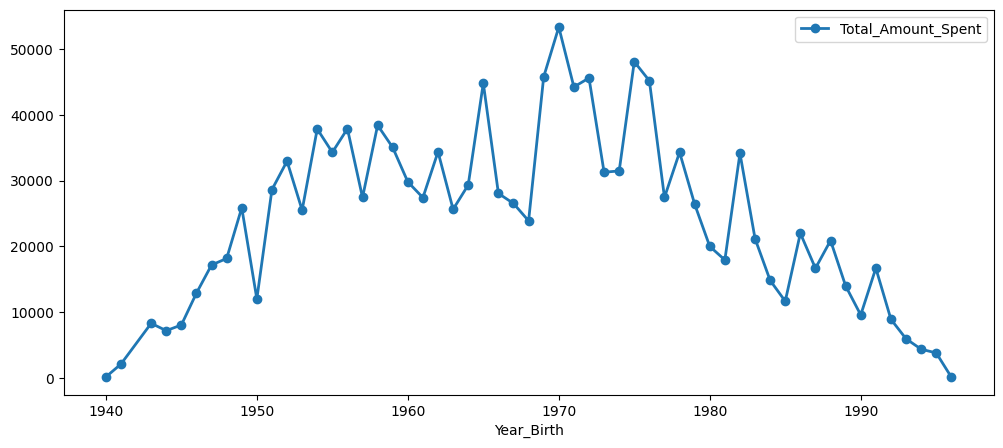

In [ ]:
pd.pivot_table(
    data=df,
    index=["Year_Birth"],
    values="Total_Amount_Spent",
    aggfunc=np.sum,
).plot(kind="line", marker="o", linewidth=2, figsize=(12, 5))

- The plot clearly shows that the total amount spent has declined over the years.
- The plot shows the highest increase in the amount spent from August to September 2012. 

`Total_Amount_Spent vs Income`

In [ ]:
df = df.drop(['Reg_year','Reg_quarter','Reg_month'], axis =1)

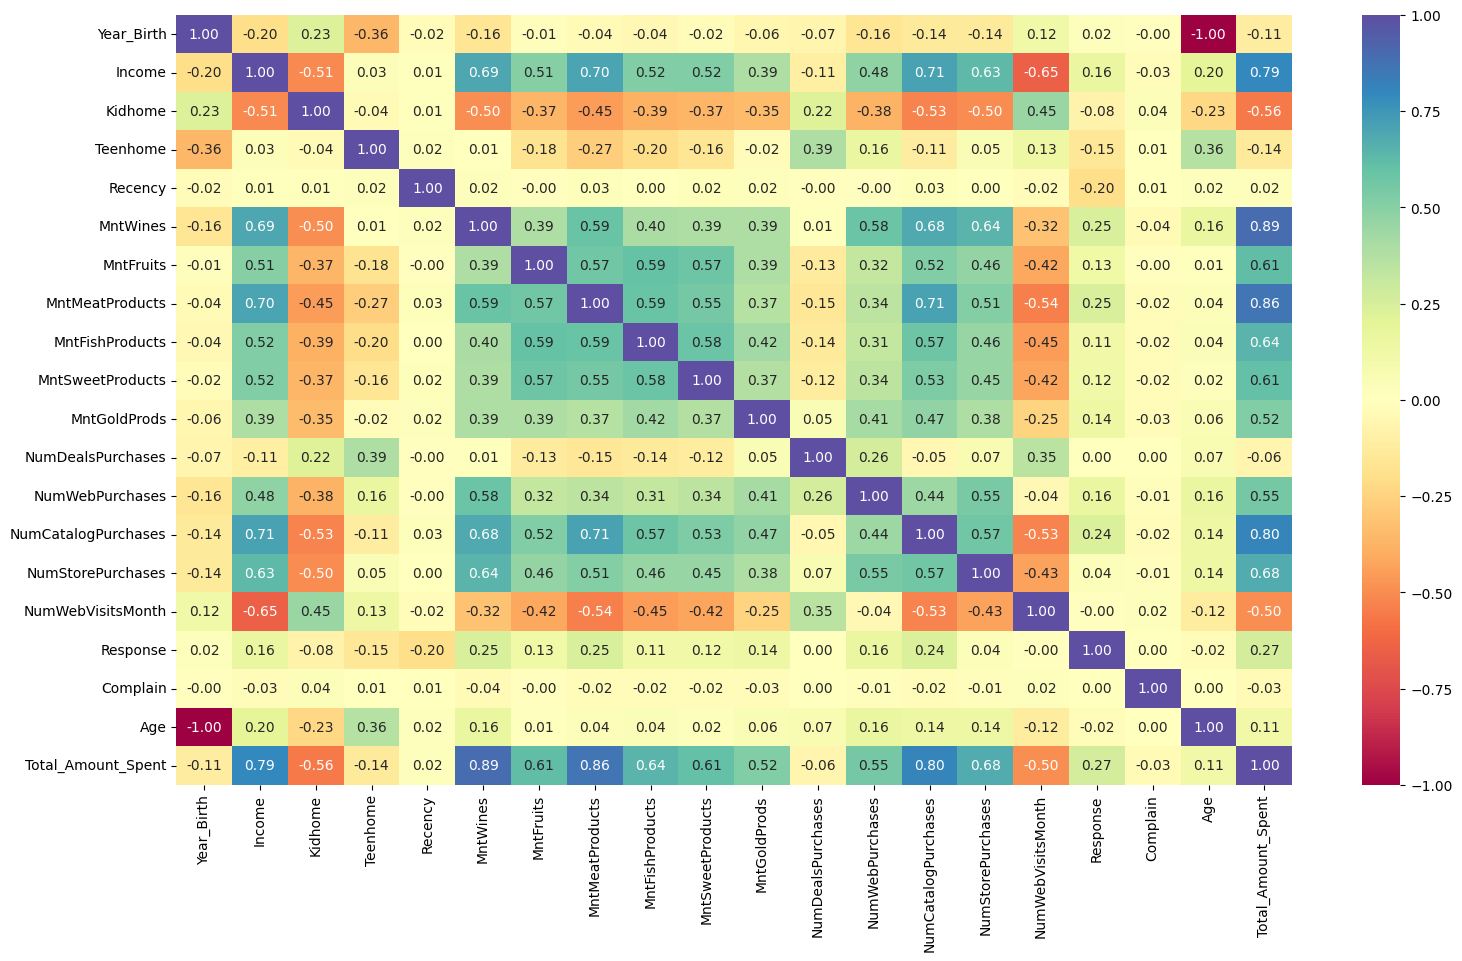

In [ ]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- As expected, age and year of birth have a high negative correlation. We can drop one of them.
- Registration month and quarter columns are highly correlated which can be expected as we extracted these columns from the same column.
- We can drop one of the columns in a quarter or month as they are almost perfectly correlated.
- Total amount spent is correlated with variables they are associated with and hence we can drop this column.
- Number of purchases is positively correlated with income which can be expected as customers with higher income might spend more than customers with lower income.

`Total_Amount_Spent vs Education` 

<Axes: xlabel='Education', ylabel='Total_Amount_Spent'>

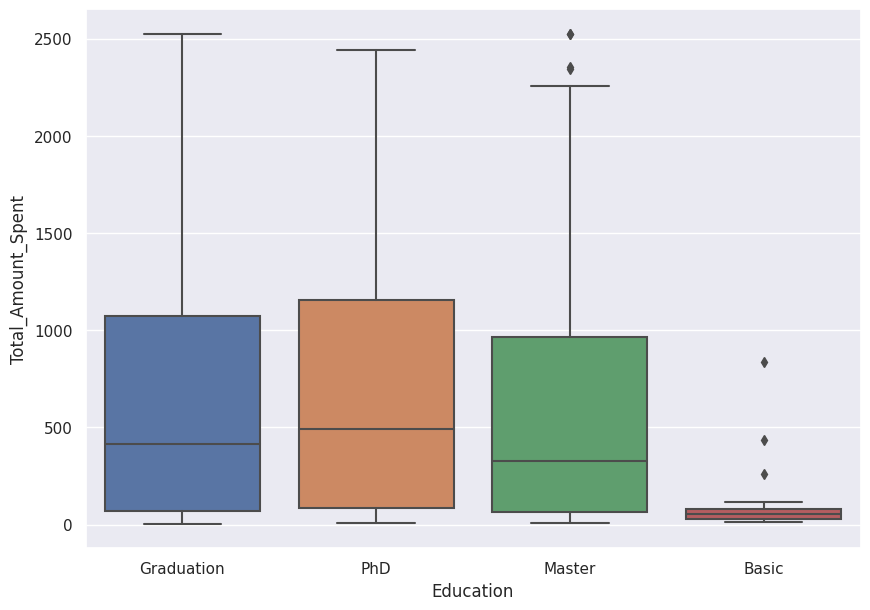

In [ ]:
sns.boxplot(y="Total_Amount_Spent", x="Education", data=df, orient="vertical")

- As expected, the amount spent increases with the increase in education level.
- Customers with graduate-level education spend slightly more than customers with master-level education. 

`Total_Amount_Spent vs Marital_status`

<Axes: xlabel='Marital_Status', ylabel='Total_Amount_Spent'>

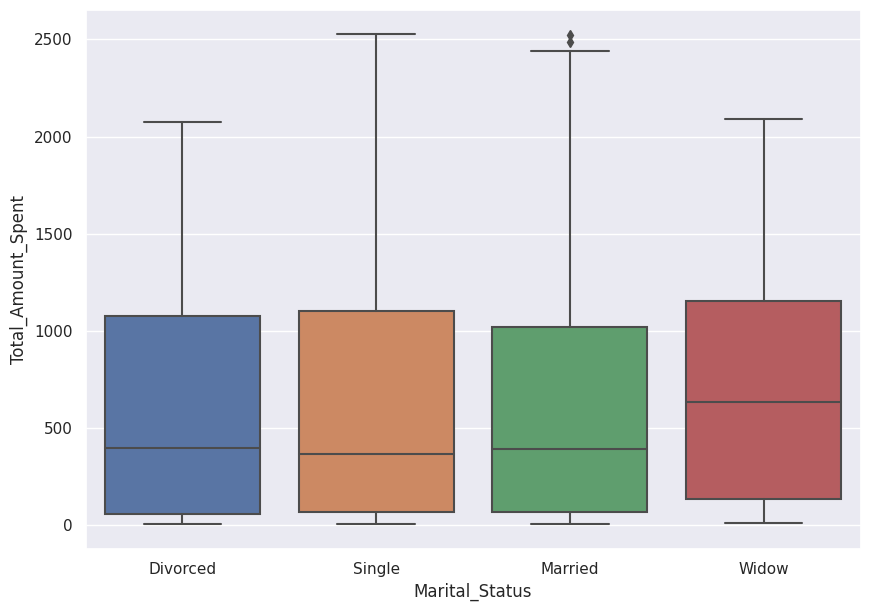

In [ ]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(y="Total_Amount_Spent", x="Marital_Status", data=df, orient="vertical")

- We can see that the total amount spent is higher for widowed customers.
- No significant difference in the amount spent by single, married or divorced customers.

`Recency,Age,Income,Total_Amount_Spent`

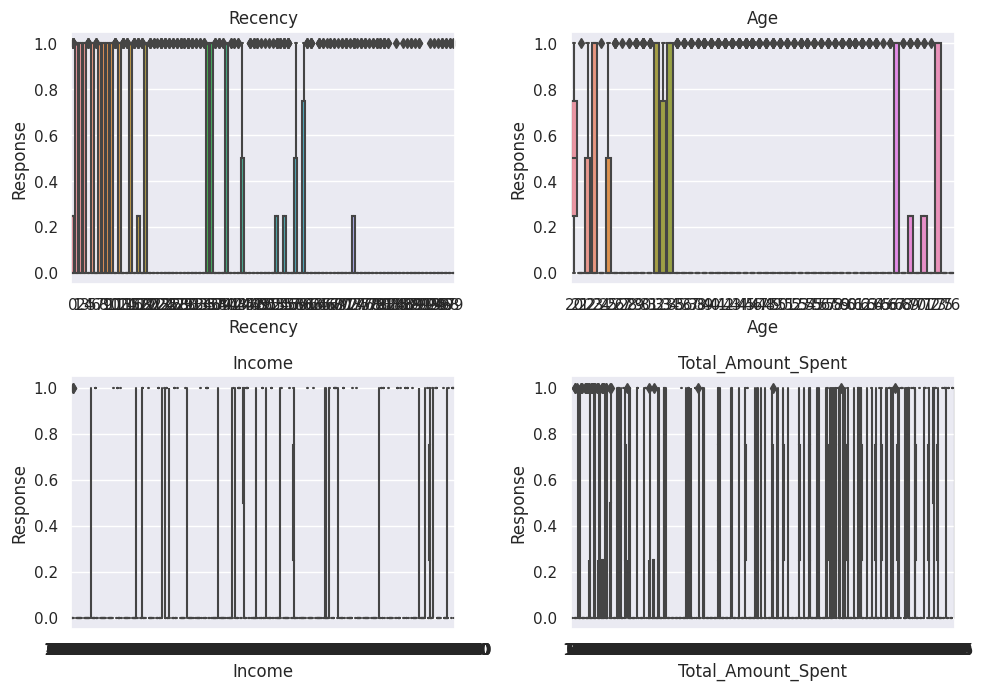

In [ ]:
cols = df[["Recency", "Age", "Income", "Total_Amount_Spent"]].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(y=df["Response"], x=df[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

- Customers with lower recency i.e. less number of days since the last purchase, are more likely to take the offer.
- Response does not depend much on age.
- Customers with higher income are more likely to take the offer.
- Customers who spent more in the last 2 years are more likely to take the offer.

`Education vs Response`

Response       0    1   All
Education                  
All         1902  334  2236
Graduation   974  152  1126
PhD          384  101   485
Master       492   79   571
Basic         52    2    54
------------------------------------------------------------------------------------------------------------------------


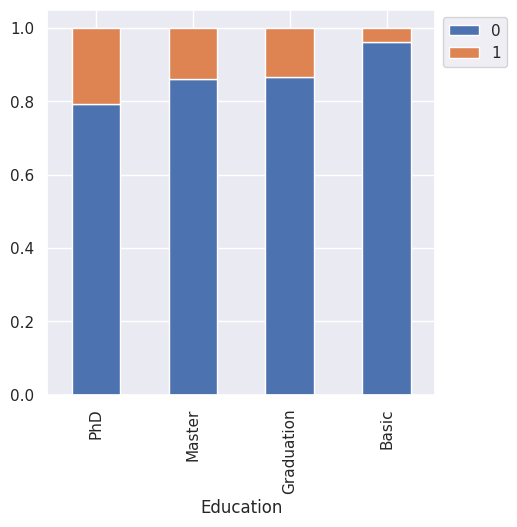

In [ ]:
stacked_barplot(df, "Education", "Response")

- We can see a clear trend here that customers with higher education are more likely to take the offer.  

`Marital_Status vs Response`

Response           0    1   All
Marital_Status                 
All             1902  334  2236
Married         1284  158  1442
Single           377  109   486
Divorced         183   48   231
Widow             58   19    77
------------------------------------------------------------------------------------------------------------------------


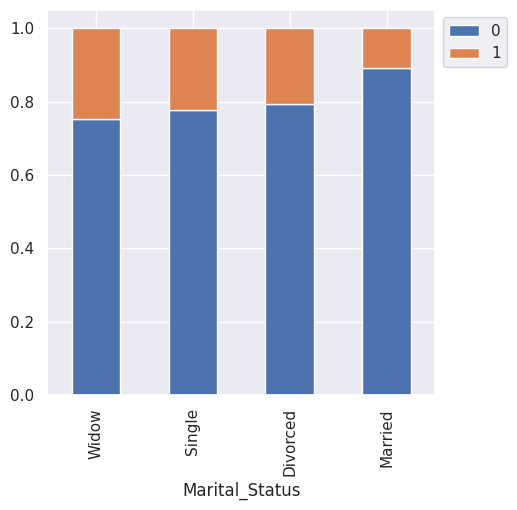

In [ ]:
stacked_barplot(df, "Marital_Status", "Response")

- We saw earlier that number of married customers is much more than single or divorced but divorced/widow customers are more likely to take the offer.
- Single customers are more likely to take the offer than married customers.

`Kidhome vs Response`

Response     0    1   All
Kidhome                  
All       1902  334  2236
0         1069  222  1291
1          787  110   897
2           46    2    48
------------------------------------------------------------------------------------------------------------------------


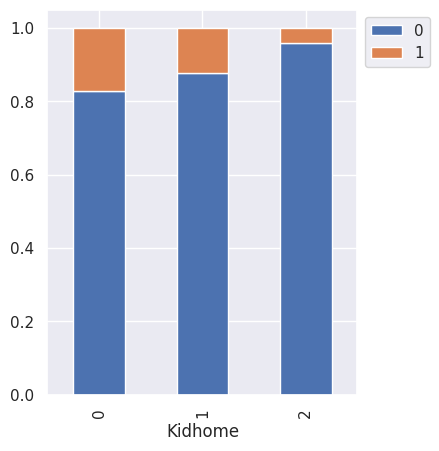

In [ ]:
stacked_barplot(df, "Kidhome", "Response")

- We can see that the number of kids increases, chances of customers taking the offer decreases.
- Customers with no kids at home are more likely to take the offer which can be expected as this includes single customers as well.

`Teenhome vs Response`

Response     0    1   All
Teenhome                 
All       1902  334  2236
0          918  237  1155
1          937   92  1029
2           47    5    52
------------------------------------------------------------------------------------------------------------------------


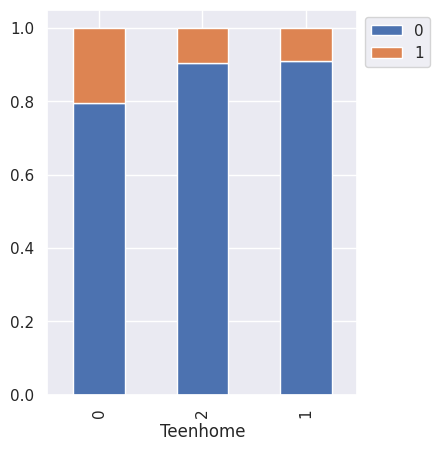

In [ ]:
stacked_barplot(df, "Teenhome", "Response")

- Customers with no teens at home are most likely to take the offer.
- Customers with two teens are more likely to take the offer than customers with 1 teenager.

- Number of customers taking the offer is decreasing each subsequent year.
- Let's explore this further for month-wise distribution for each of the year.

In [ ]:
spark_df = spark.createDataFrame(df)

In [ ]:
spark_df.show(5)

+----------+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+---+------------------+
|Year_Birth| Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|Age|Total_Amount_Spent|
+----------+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+---+------------------+
|      1970|Graduation|      Divorced|84835.0|      0|       0|      0|     189|      104|            379|            111|             189|         

### Feature Engineering

In [ ]:
from pyspark.sql.functions import col

# Selecting all columns except the ones to be dropped
spark_df = spark_df.select([c for c in spark_df.columns if c not in ["Year_Birth", "Dt_Customer", "Reg_quarter", "Total_Amount_Spent"]])


In [ ]:
for i in spark_df.columns:
  print("missing in",i,spark_df.filter(spark_df[i].isNull()).count())

missing in Education 0
missing in Marital_Status 0
missing in Income 24
missing in Kidhome 0
missing in Teenhome 0
missing in Recency 0
missing in MntWines 0
missing in MntFruits 0
missing in MntMeatProducts 0
missing in MntFishProducts 0
missing in MntSweetProducts 0
missing in MntGoldProds 0
missing in NumDealsPurchases 0
missing in NumWebPurchases 0
missing in NumCatalogPurchases 0
missing in NumStorePurchases 0
missing in NumWebVisitsMonth 0
missing in Response 0
missing in Complain 0
missing in Age 0


In [ ]:
from pyspark.sql.functions import mean, when, col

# Calculate mean of Income column
mean_income = spark_df.select(mean("Income")).collect()[0][0]

# Replace missing values in Income column with mean value
spark_df = spark_df.withColumn("Income", when(col("Income").isNull(), mean_income).otherwise(col("Income")))

In [ ]:
spark_df.dtypes

[('Education', 'string'),
 ('Marital_Status', 'string'),
 ('Income', 'double'),
 ('Kidhome', 'int'),
 ('Teenhome', 'int'),
 ('Recency', 'int'),
 ('MntWines', 'int'),
 ('MntFruits', 'int'),
 ('MntMeatProducts', 'int'),
 ('MntFishProducts', 'int'),
 ('MntSweetProducts', 'int'),
 ('MntGoldProds', 'int'),
 ('NumDealsPurchases', 'int'),
 ('NumWebPurchases', 'int'),
 ('NumCatalogPurchases', 'int'),
 ('NumStorePurchases', 'int'),
 ('NumWebVisitsMonth', 'int'),
 ('Response', 'int'),
 ('Complain', 'int'),
 ('Age', 'int')]

Converting the columns with categorical values into string types so that we can embed them using stringindexer or OneHotEncoding.

In [ ]:
from pyspark.sql.types import StringType
spark_df = spark_df.withColumn("Kidhome",spark_df["Kidhome"].cast(StringType()))
spark_df = spark_df.withColumn("Teenhome",spark_df["Teenhome"].cast(StringType()))
spark_df = spark_df.withColumn("Response",spark_df["Response"].cast(StringType()))
spark_df = spark_df.withColumn("Complain",spark_df["Complain"].cast(StringType()))

#### Handling categorical columns

In [ ]:
from pyspark.ml.feature import StringIndexer
str_indexer=StringIndexer(inputCol='Education',outputCol='Education_cat')
str_indexer.setHandleInvalid("error")
cat_indexed=str_indexer.fit(spark_df).transform(spark_df)
cat_indexed.head(1)

[Row(Education='Graduation', Marital_Status='Divorced', Income=84835.0, Kidhome='0', Teenhome='0', Recency=0, MntWines=189, MntFruits=104, MntMeatProducts=379, MntFishProducts=111, MntSweetProducts=189, MntGoldProds=218, NumDealsPurchases=1, NumWebPurchases=4, NumCatalogPurchases=4, NumStorePurchases=6, NumWebVisitsMonth=1, Response='1', Complain='0', Age=46, Education_cat=0.0)]

In [ ]:
from pyspark.ml.feature import StringIndexer
str_indexer=StringIndexer(inputCol='Marital_Status',outputCol='Marital_Status_cat')
str_indexer.setHandleInvalid("error")
cat_indexed=str_indexer.fit(cat_indexed).transform(cat_indexed)
cat_indexed.head(1)

[Row(Education='Graduation', Marital_Status='Divorced', Income=84835.0, Kidhome='0', Teenhome='0', Recency=0, MntWines=189, MntFruits=104, MntMeatProducts=379, MntFishProducts=111, MntSweetProducts=189, MntGoldProds=218, NumDealsPurchases=1, NumWebPurchases=4, NumCatalogPurchases=4, NumStorePurchases=6, NumWebVisitsMonth=1, Response='1', Complain='0', Age=46, Education_cat=0.0, Marital_Status_cat=2.0)]

In [ ]:
from pyspark.ml.feature import StringIndexer
str_indexer=StringIndexer(inputCol='Kidhome',outputCol='Kidhome_cat')
str_indexer.setHandleInvalid("error")
cat_indexed=str_indexer.fit(cat_indexed).transform(cat_indexed)
cat_indexed.head(1)

[Row(Education='Graduation', Marital_Status='Divorced', Income=84835.0, Kidhome='0', Teenhome='0', Recency=0, MntWines=189, MntFruits=104, MntMeatProducts=379, MntFishProducts=111, MntSweetProducts=189, MntGoldProds=218, NumDealsPurchases=1, NumWebPurchases=4, NumCatalogPurchases=4, NumStorePurchases=6, NumWebVisitsMonth=1, Response='1', Complain='0', Age=46, Education_cat=0.0, Marital_Status_cat=2.0, Kidhome_cat=0.0)]

In [ ]:
from pyspark.ml.feature import StringIndexer
str_indexer=StringIndexer(inputCol='Teenhome',outputCol='Teenhome_cat')
str_indexer.setHandleInvalid("error")
cat_indexed=str_indexer.fit(cat_indexed).transform(cat_indexed)
cat_indexed.head(1)

[Row(Education='Graduation', Marital_Status='Divorced', Income=84835.0, Kidhome='0', Teenhome='0', Recency=0, MntWines=189, MntFruits=104, MntMeatProducts=379, MntFishProducts=111, MntSweetProducts=189, MntGoldProds=218, NumDealsPurchases=1, NumWebPurchases=4, NumCatalogPurchases=4, NumStorePurchases=6, NumWebVisitsMonth=1, Response='1', Complain='0', Age=46, Education_cat=0.0, Marital_Status_cat=2.0, Kidhome_cat=0.0, Teenhome_cat=0.0)]

In [ ]:
from pyspark.ml.feature import StringIndexer
str_indexer=StringIndexer(inputCol='Response',outputCol='Response_cat')
str_indexer.setHandleInvalid("error")
cat_indexed=str_indexer.fit(cat_indexed).transform(cat_indexed)
cat_indexed.head(1)

[Row(Education='Graduation', Marital_Status='Divorced', Income=84835.0, Kidhome='0', Teenhome='0', Recency=0, MntWines=189, MntFruits=104, MntMeatProducts=379, MntFishProducts=111, MntSweetProducts=189, MntGoldProds=218, NumDealsPurchases=1, NumWebPurchases=4, NumCatalogPurchases=4, NumStorePurchases=6, NumWebVisitsMonth=1, Response='1', Complain='0', Age=46, Education_cat=0.0, Marital_Status_cat=2.0, Kidhome_cat=0.0, Teenhome_cat=0.0, Response_cat=1.0)]

In [ ]:
from pyspark.ml.feature import StringIndexer
str_indexer=StringIndexer(inputCol='Complain',outputCol='Complain_cat')
str_indexer.setHandleInvalid("error")
cat_indexed=str_indexer.fit(cat_indexed).transform(cat_indexed)
cat_indexed.head(1)

[Row(Education='Graduation', Marital_Status='Divorced', Income=84835.0, Kidhome='0', Teenhome='0', Recency=0, MntWines=189, MntFruits=104, MntMeatProducts=379, MntFishProducts=111, MntSweetProducts=189, MntGoldProds=218, NumDealsPurchases=1, NumWebPurchases=4, NumCatalogPurchases=4, NumStorePurchases=6, NumWebVisitsMonth=1, Response='1', Complain='0', Age=46, Education_cat=0.0, Marital_Status_cat=2.0, Kidhome_cat=0.0, Teenhome_cat=0.0, Response_cat=1.0, Complain_cat=0.0)]

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
cat_indexed.columns 

['Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Response',
 'Complain',
 'Age',
 'Education_cat',
 'Marital_Status_cat',
 'Kidhome_cat',
 'Teenhome_cat',
 'Response_cat',
 'Complain_cat']

In [ ]:
spark_df.show(1)

+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+---+
| Education|Marital_Status| Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|Response|Complain|Age|
+----------+--------------+-------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+--------+--------+---+
|Graduation|      Divorced|84835.0|      0|       0|      0|     189|      104|            379|            111|             189|         218|                1|              4|                  4|                6|                1|       

### Handling numerical columns

In [ ]:
assembler=VectorAssembler(inputCols=[
 'Income',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Age',
 'Education_cat',
 'Marital_Status_cat',
 'Kidhome_cat',
 'Teenhome_cat',
 'Complain_cat'],outputCol="features")
output=assembler.transform(cat_indexed)
output.select(['features','Response_cat']).show(5)

+--------------------+------------+
|            features|Response_cat|
+--------------------+------------+
|[84835.0,0.0,189....|         1.0|
|[57091.0,0.0,464....|         1.0|
|[67267.0,0.0,134....|         0.0|
|(19,[0,2,4,8,9,11...|         0.0|
|[21474.0,0.0,6.0,...|         1.0|
+--------------------+------------+
only showing top 5 rows



In [ ]:
fin_data=output.select(['features','Response_cat'])

##### Train-test split of Data

In [ ]:
train_data,test_data=fin_data.randomSplit([0.7,0.3])
train_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Response_cat: double (nullable = false)



### Random Forest Model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Create Random Forest Classifier model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = "Response_cat")


rfModel = rf.fit(train_data)
# predictions = rfModel.transform(test_data)


In [ ]:

# Make predictions on test data
predictions = rfModel.transform(test_data)

# Evaluate model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Response_cat")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("AUC: {:.4f}".format(auc))


AUC: 0.7796


In [ ]:

# Evaluate model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Response_cat")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))
print("Accuracy: {:.4f}".format(accuracy))


Precision: 0.8445
Recall: 0.8702
F1-score: 0.8293
Accuracy: 0.8702


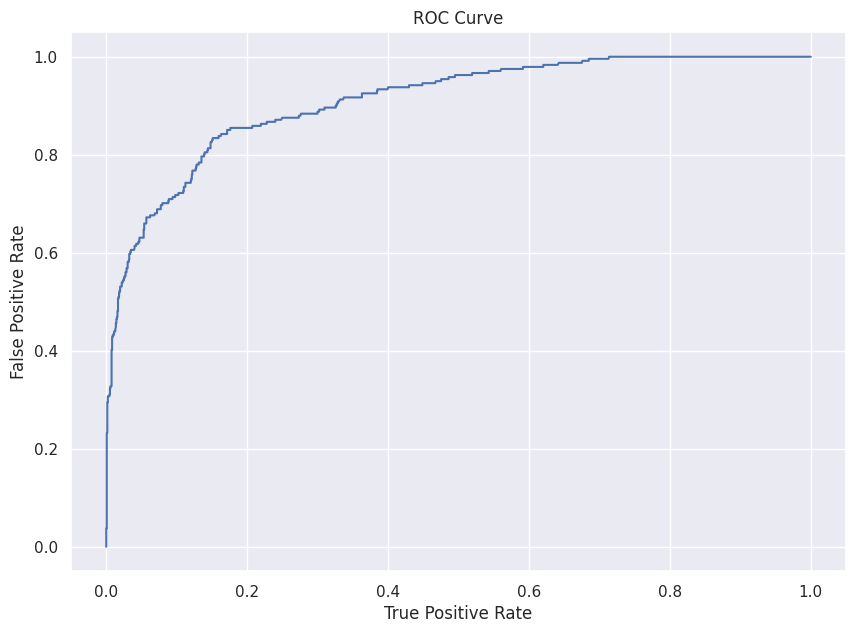

Training set areaUnderROC: 0.9094036805640884


In [ ]:
trainingSummary = rfModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

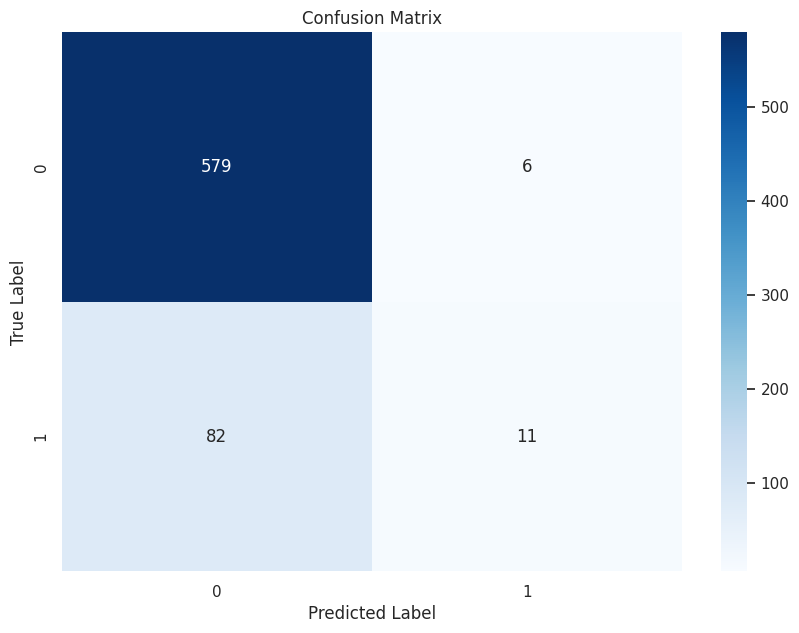

In [ ]:

# Plot confusion matrix
cm = confusion_matrix(predictions.select("Response_cat").rdd.map(lambda x: x[0]).collect(),
                      predictions.select("prediction").rdd.map(lambda x: x).collect())
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


<b> Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc



# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = "Response_cat")

dt_model = dt.fit(train_data)

In [ ]:

dt_predictions = dt_model.transform(test_data)
dt_evaluator = BinaryClassificationEvaluator(labelCol = "Response_cat")
dt_auc = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "areaUnderROC"})
print("Decision Tree Classifier")
print("AUC: {:.4f}".format(dt_auc))
dt_evaluator = MulticlassClassificationEvaluator(labelCol = "Response_cat")
dt_precision = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "weightedPrecision"})
dt_recall = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "weightedRecall"})
dt_f1_score = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "f1"})
dt_accuracy = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "accuracy"})
print("Precision: {:.4f}".format(dt_precision))
print("Recall: {:.4f}".format(dt_recall))
print("F1-score: {:.4f}".format(dt_f1_score))
print("Accuracy: {:.4f}".format(dt_accuracy))


Decision Tree Classifier
AUC: 0.3381
Precision: 0.8339
Recall: 0.8599
F1-score: 0.8413
Accuracy: 0.8599


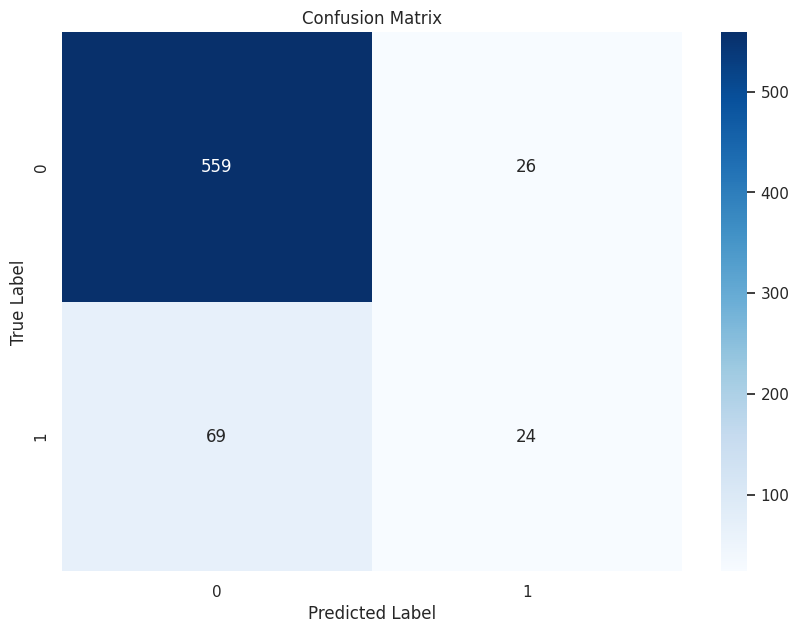

In [ ]:

# Plot confusion matrix
cm = confusion_matrix(dt_predictions.select("Response_cat").rdd.map(lambda x: x[0]).collect(),
                      dt_predictions.select("prediction").rdd.map(lambda x: x).collect())
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


<b> Gradient boosting

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Create Gradient Boosting Classifier model
gbt = GBTClassifier(featuresCol = 'features', labelCol = "Response_cat")


# Fit cross-validator on train data
gbt_model = gbt.fit(train_data)


In [ ]:

# Make predictions on test data
predictions = gbt_model.transform(test_data)

# Evaluate model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol = "Response_cat")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("AUC: {:.4f}".format(auc))

# Evaluate model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol = "Response_cat")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))
print("Accuracy: {:.4f}".format(accuracy))



AUC: 0.7740
Precision: 0.8410
Recall: 0.8614
F1-score: 0.8478
Accuracy: 0.8614


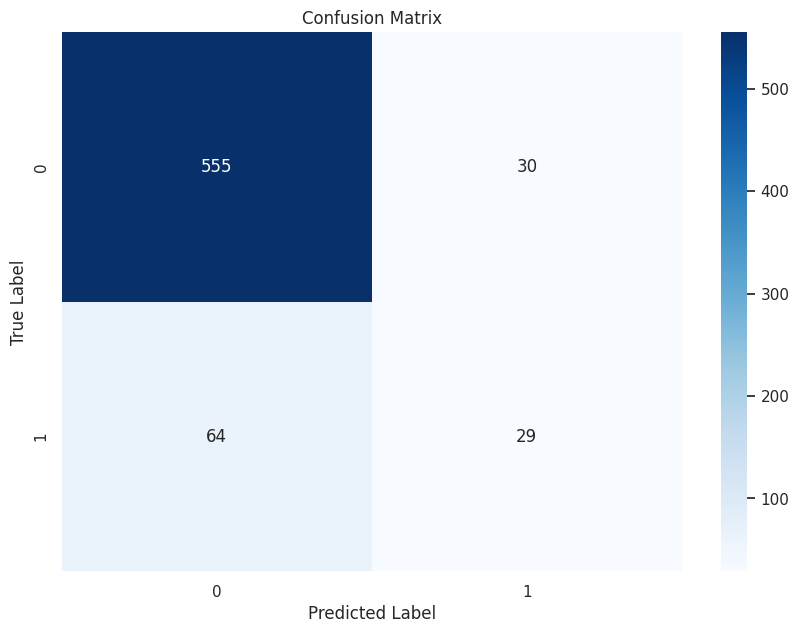

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(predictions.select("Response_cat").rdd.map(lambda x: x[0]).collect(),
                      predictions.select("prediction").rdd.map(lambda x: x).collect())
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


<b> Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc



# Create Logistic Regression Classifier model
lr = LogisticRegression(featuresCol = 'features', labelCol = "Response_cat")

# Fit cross-validator on train data
lr_model = lr.fit(train_data)


In [ ]:

# Make predictions on test data
predictions = lr_model.transform(test_data)

# Evaluate model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol = "Response_cat")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("AUC: {:.4f}".format(auc))

# Evaluate model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator( labelCol = "Response_cat")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1_score))
print("Accuracy: {:.4f}".format(accuracy))



AUC: 0.8039
Precision: 0.8492
Recall: 0.8732
F1-score: 0.8500
Accuracy: 0.8732


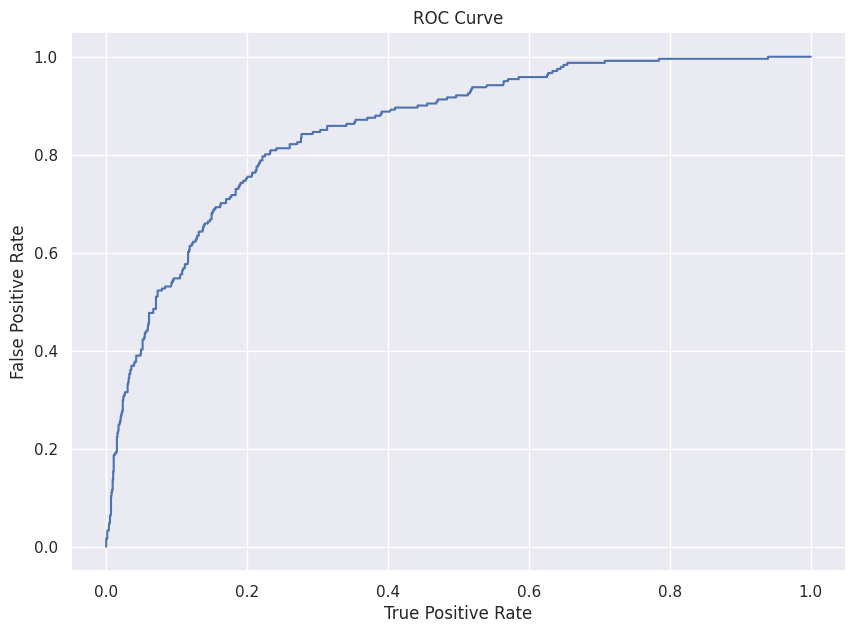

Training set areaUnderROC: 0.8531334574680864


In [ ]:
trainingSummary = lr_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

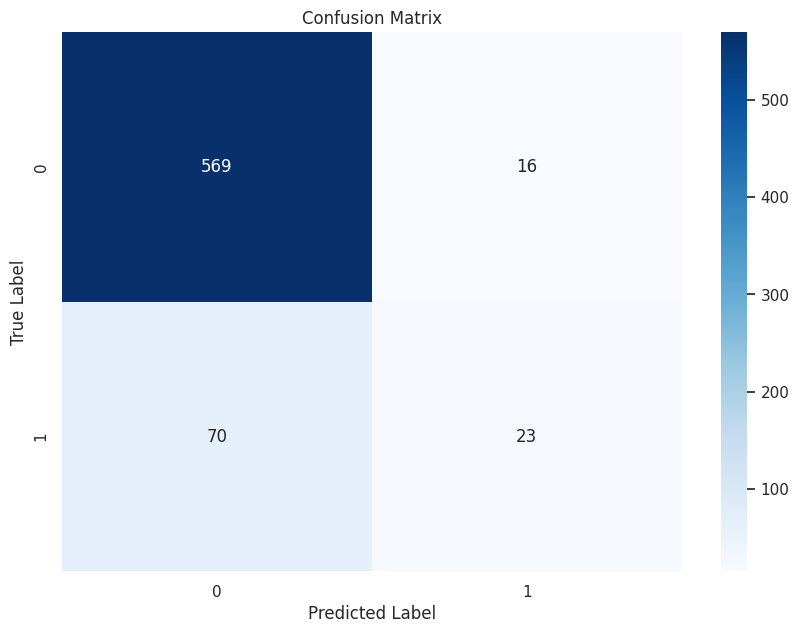

In [ ]:

# Plot confusion matrix
cm = confusion_matrix(predictions.select("Response_cat").rdd.map(lambda x: x[0]).collect(),
                      predictions.select("prediction").rdd.map(lambda x: x).collect())
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


<b> Obtaining feature importances using best model

In [ ]:
importances=gbt_model.featureImportances

In [ ]:
import numpy as np
features = data.drop('Response')
indices = np.argsort(importances)

In [ ]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.07800
Feature: 1, Score: 0.12451
Feature: 2, Score: 0.08239
Feature: 3, Score: 0.04770
Feature: 4, Score: 0.07316
Feature: 5, Score: 0.04616
Feature: 6, Score: 0.04718
Feature: 7, Score: 0.05563
Feature: 8, Score: 0.03905
Feature: 9, Score: 0.02851
Feature: 10, Score: 0.06371
Feature: 11, Score: 0.06170
Feature: 12, Score: 0.05392
Feature: 13, Score: 0.07160
Feature: 14, Score: 0.01734
Feature: 15, Score: 0.06697
Feature: 16, Score: 0.00241
Feature: 17, Score: 0.04005
Feature: 18, Score: 0.00000
